## **1 Non-Linear Optimization, MLE for Normal Distribution**

The goal here is to use the log-likelihood function to probe the solution space for the mean and var with the maximum log-likelihood.

In [7]:
Negative.LL.Normal<-function(mu.Sig.parameters, Sample.Vector) {
    n <- length(Sample.Vector)
    mn <- mu.Sig.parameters[1]
    var <- mu.Sig.parameters[2]
    sum_sqrs <- sum((Sample.Vector - mn)^2)
    
    (n/2)*log(2*pi*var)+(1/(2*var))*sum_sqrs
}

In [2]:
Norm.Sample.Vector<-read.csv("sample_for_optimization.csv",header=TRUE,sep=",")[,1]
head(Norm.Sample.Vector)

[1] 12.6567272 10.8362391  4.1087307 10.9831141 10.7719944 -0.9756093

In [3]:
var(Norm.Sample.Vector)

[1] 24.75509

In [8]:
Optimized.Negative.Log.Likelihood.optim<-optim(c(7,4),
                                               Negative.LL.Normal,
                                               Sample.Vector=Norm.Sample.Vector,
                                               method="L-BFGS-B",
                                               hessian=TRUE,
                                               lower=c(-Inf,0),
                                               control=list(trace=1))

iter   10 value 3024.314081
final  value 3022.953774 
converged


In [9]:
Optimized.Negative.Log.Likelihood.optim$par

[1] 10.22552 24.73032

In [10]:
Optimized.Negative.Log.Likelihood.optim$value

[1] 3022.954

In [11]:
Optimized.Negative.Log.Likelihood.optim$counts

function gradient 
      17       17

In [12]:
Optimized.Negative.Log.Likelihood.optim$convergence

[1] 0

### **1.2 Analysis of the obtained estimates**

In [13]:
rbind(Mean.Var=c(mean(Norm.Sample.Vector),var(Norm.Sample.Vector)),
      Optim.Output=Optimized.Negative.Log.Likelihood.optim$par)

Mean.Var,10.22552,24.75509
Optim.Output,10.22552,24.73032


In [35]:
Transform.Optim.Output <- function(params, len_vec) {
    n_params <- length(params)
    output <- c(params[1])
    output <- c(output, params[2]*len_vec/(len_vec - 1))
}

In [36]:
Optim.Output.Transformed <- Transform.Optim.Output(Optimized.Negative.Log.Likelihood.optim$par, length(Norm.Sample.Vector))

In [37]:
rbind(Mean.Var=c(mean(Norm.Sample.Vector),var(Norm.Sample.Vector)),
      Optim.Output.Transformed=Optim.Output.Transformed)

Mean.Var,10.22552,24.75509
Optim.Output.Transformed,10.22552,24.75508


Basically, using the MLE methods gives biased variance estimate for normal distributions. The bias can be analytically derived, see [http://www.ee.columbia.edu/~dliang/files/mle_biased.pdf]. You can overcome this bias by adjusting variance by $\frac{1}{1-N}$.

## **Fisher's Score, Fisher's Information**

### **2.1 Fisher's Score**

Basically, Fisher's Information Matrix is second derivatives of log-likelihood function with regards to each of the parameters to estimate. Used to estimate the parameters via the Newton-Raphson algorithm. Very similar to other optimization problems. Though faster algorithms exist.

In [38]:
(Biased.Var<- var(Norm.Sample.Vector)*(length(Norm.Sample.Vector)-1)/length(Norm.Sample.Vector))

[1] 24.73033

Fisher's score is basically how much more information about the true parameters can be gained at given parameters. Therefore, when the parameters are the same as the true parameters, the Fisher's score at those parameters are 0.

In [44]:
# Derivative of mean for the loglik function == 0
(1/Biased.Var)*sum((Norm.Sample.Vector-mean(Norm.Sample.Vector)))

[1] -2.585847e-14

In [45]:
# Derivative of sd for the loglik function == 0
-(length(Norm.Sample.Vector)/(2*Biased.Var))+1/(2*Biased.Var^2)*sum((Norm.Sample.Vector-mean(Norm.Sample.Vector))^2)

[1] 3.552714e-15

### **2.2 Observed Fisher's Information**

In [46]:
Optimized.Negative.Log.Likelihood.optim$hessian

4.043619e+01,-1.136868e-07
-1.136868e-07,8.175431e-01


In [48]:
# Estimating Hessian 1.1:

# This is the second derivative of log likelihood with respect to mu and mu

length(Norm.Sample.Vector)/Biased.Var

[1] 40.43617

In [51]:
# Hessian 1.2 and 2.1 are the same. In this case does not matter whether use derivative of mu or var first.
# Not necessarily the same as the one given by the optim() function due to methodology differences

(1/(Biased.Var^2))*sum(Norm.Sample.Vector-mean(Norm.Sample.Vector))

[1] -1.045617e-15

In [52]:
# Hessian 2.2: second derivative of loglik w.r. to var twice

-(length(Norm.Sample.Vector)/(2*Biased.Var^2)) + (1/Biased.Var^3)*sum((Norm.Sample.Vector-mean(Norm.Sample.Vector))^2)

[1] 0.8175421

### **2.3 Expected Fisher's Information**

Basically, using definition of mu and var to get at the Hessian matrix easily. Not sure what the point is here since the goal of the Hessian is to estimate mean and var but... maybe just to prove a point?

## **4 Example: Simple linear regression**

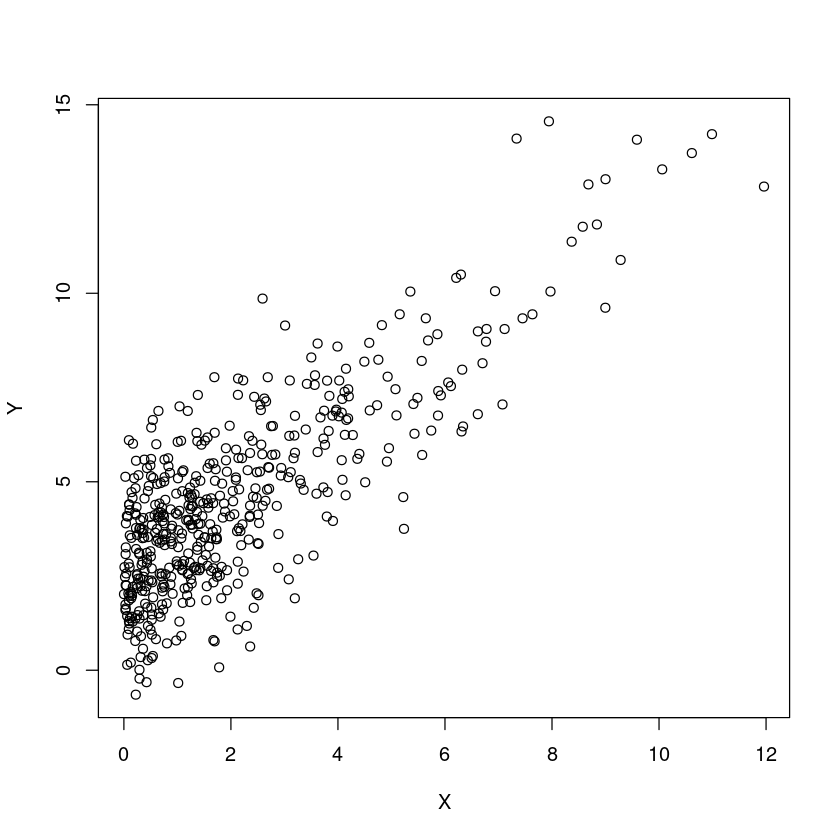

In [53]:
nSample<-500
sigmaEps<-1.5
set.seed(927436)
Eps<-rnorm(nSample,0,sigmaEps)
beta1<-1
beta0<-2.5
lambda<-.5
X<-rexp(nSample,lambda)
Y<-beta0+beta1*X+Eps
plot(X,Y)

In [54]:
dtf<-data.frame(X=X,Y=Y)
head(dtf)

,X,Y
,<dbl>,<dbl>
1,1.980506,4.0826325
2,2.542126,5.2707668
3,1.040133,6.9997564
4,1.694994,0.7666407
5,0.102001,1.9767673
6,2.751328,6.4738524


In [56]:
dim(dtf)[1]

[1] 500

In [59]:
linModLL <- function(params, regSample) {
    b0 <- params[1]
    b1 <- params[2]
    sigma <- params[3]
    
    LL <- 0
    for (row_idx in 1:dim(regSample)[1]) {
        LL <- LL - dnorm(regSample[row_idx,2], b0+b1*regSample[row_idx,1], sigma, log = T)
    }
    LL
}

In [60]:
linModLL(c(Beta0=beta0+1,Beta1=beta1+1,Sigma=sigmaEps),dtf)

[1] 2523.769

In [61]:
linModLL(c(Beta0=beta0,Beta1=beta1,Sigma=sigmaEps),dtf)

[1] 931.3951

In [64]:
manualMLE<-optim(c(0,0,1), # starting points vector
linModLL, # function to optimize
regSample=dtf, # other args in function, need to be named like in original function
method="L-BFGS-B",
hessian=TRUE,
lower=c(-Inf, -Inf, 0), # bounds, lower bound here, must have provide for all parameters (3 in this case). last param is sigma so lower bound is 0
control=list(trace=1))

iter   10 value 931.485591
final  value 930.111159 
converged


In [65]:
manualMLE$par

[1] 2.4929620 0.9761939 1.5547032

In [66]:
manualMLE$value

[1] 930.1112

In [67]:
manualMLE$counts

function gradient 
      18       18

In [68]:
manualMLE$hessian

2.068593e+02,4.271236e+02,1.668923e-03
4.271236e+02,1.789044e+03,7.890620e-03
1.668923e-03,7.890620e-03,4.137191e+02


In [69]:
linM<-lm(Y~X,dtf)
res<-rbind(LM=c(linM$coefficients,summary(linM)$sigma),
           Manual=manualMLE$par,
           Actual=c(beta0,beta1,sigmaEps) )
colnames(res)<-c("Intercept","Slope","Sigma")
res

,Intercept,Slope,Sigma
LM,2.492960,0.9761977,1.557821
Manual,2.492962,0.9761939,1.554703
Actual,2.500000,1.0000000,1.500000
